<a href="https://colab.research.google.com/github/ThisDavidAdams/MMR-summarization/blob/main/WCEP_MMR_Summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Clone WCEP Repository and install dependencies


In [ ]:
!git clone https://github.com/complementizer/wcep-mds-dataset
# Note: Kindly change line 4 in experiments/evaluate.py to 'import experiment.utils' from 'import utils'

%cd wcep-mds-dataset

Cloning into 'wcep-mds-dataset'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 125 (delta 65), reused 89 (delta 37), pack-reused 0
Receiving objects: 100% (125/125), 1.09 MiB | 8.01 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/wcep-mds-dataset


In [ ]:
!pip install -r experiments/requirements.txt
!python -m nltk.downloader punkt

     |████████████████████████████████| 6.8MB 4.9MB/s 
     |████████████████████████████████| 1.6MB 36.9MB/s 
     |████████████████████████████████| 1.4MB 48.4MB/s 
  Cloning git://github.com/clic-lab/newsroom.git to /tmp/pip-install-xejkux8j/newsroom
  Running command git clone -q git://github.com/clic-lab/newsroom.git /tmp/pip-install-xejkux8j/newsroom
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 184kB 40.0MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434690 sha256=0d0f358f83ec1f5db49ce1aec2b758f7fd11c0af6249378e5db26a8b23ec61ab
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
  Created wheel for newsroom: filename=newsroom-0.1-cp37-none-any.whl size=281701 sha256=2e70c8954f80c08cb7bdf6f33a244a2525584f1174aa4c65126be48940c8af68
  Stored in directory: /tmp/pip-ephem-wheel-cache-chuw0w7j/wheels/d5/c4/c7/23cd619d0c4202ef81a4509bfbaa6d90d89200c3ee15e518

## Download the test dataset

WCEP-100

In [ ]:
!mkdir WCEP

In [ ]:
import experiments.utils as utils

test_data = list(utils.read_jsonl('/content/gdrive/MyDrive/MMRSumm/data/test_data.jsonl'))
partial_test_data = test_data[:10]
print("Number of clusters:",len(test_data))
print(test_data[0].keys())

In [ ]:
summary_max = 0
article_max = 0
for c in test_data:
  summary_max = max(summary_max,len(c['summary'].split(" ")))

  for a in c['articles']:
    if article_max < len(a['text'].split(" ")):
      long_text = a["text"]
    article_max = max(article_max,len(a['text'].split(" ")))

In [ ]:
test_data = test_data[:500]
assert len(test_data) == 500

In [ ]:
from statistics import mean
import experiments.sent_splitter as sent_splitter

sentSplitter = sent_splitter.SentenceSplitter()

article_word_count = [len(a['text'].split()) for c in test_data for a in c["articles"]]
summary_word_count = [len(c['summary'].split()) for c in test_data]
summary_sent_length = [len(sentSplitter.split_sents(c["summary"])) for c in test_data]

print("max word count of articles:",max(article_word_count))
print("max word count of summary:",max(summary_word_count))
print("avg word count of articles:", int(mean(article_word_count)))
print("avg word count of summary:", int(mean(summary_word_count)))
print("max sent count of summary:",max(summary_sent_length))
print("avg sent count of summary:",int(mean(summary_sent_length)))

max word count of articles: 3096
max word count of summary: 98
avg word count of articles: 170
avg word count of summary: 31
max sent count of summary: 5
avg sent count of summary: 1


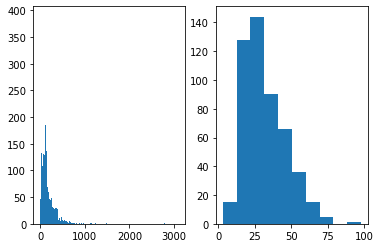

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)  
plt.hist(article_word_count, bins = 500)

plt.subplot(1, 2, 2)  
plt.hist(summary_word_count)
plt.show()

In [ ]:
max_summary_length = 150
min_summary_length = 50

## Importing the pretrained models

In [ ]:
!pip install torch
!pip install transformers
!pip install sentencepiece
!pip install spacy
!pip install bert-extractive-summarizer

In [ ]:
!python -m spacy download en_core_web_md

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
import warnings
warnings.filterwarnings("ignore")

#### Abstractive Models

In [ ]:
# PEGASUS

from transformers import PegasusForConditionalGeneration, PegasusTokenizer

class Pegasus():

  def __init__(self,device):
    self.name = "Pegasus"
    self.model_name = "google/pegasus-xsum"
    self.tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    self.device = device
    self.model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum").to(device)
  
  def summarise(self, text):
    inputs = self.tokenizer([text], max_length=512, truncation = True, return_tensors='pt').to(self.device)
    translated = self.model.generate(inputs['input_ids'],
                                        min_length=min_summary_length,
                                        max_length=max_summary_length,
                                        temperature=0.6,
                                        early_stopping=True,
                                        top_k = 50,
                                        no_repeat_ngram_size= 4,
                                    )
    
    summary = self.tokenizer.batch_decode(translated, skip_special_tokens=True)
    del inputs
    del translated

    return summary[0]



In [ ]:
# T5

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

class T5():
  
  def __init__(self,device):
    self.name = "T5"
    self.device = device
    self.model = T5ForConditionalGeneration.from_pretrained('t5-large').to(device)
    self.tokenizer = T5Tokenizer.from_pretrained('t5-large')

  def summarise(self, text):
    text = "summarize: " + text
    tokenized_text = self.tokenizer.encode(text, return_tensors="pt", truncation = True).to(self.device)

    summary_ids = self.model.generate(tokenized_text,
                                        min_length=min_summary_length,
                                        max_length=max_summary_length,
                                        temperature=0.7,
                                        early_stopping=True,
                                        top_k = 50,
                                        no_repeat_ngram_size= 4,
                                      )
    
    summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    del text
    del tokenized_text
    del summary_ids
    return summary


In [ ]:
# GPT2

from transformers import GPT2Tokenizer, GPT2LMHeadModel

class GPT2():

  def __init__(self,device):
    self.name = "GPT2"
    self.device = device
    self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device)
    self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 1020 - max_summary_length)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids, 
                                      min_length = len(input_ids[0]) + min_summary_length,
                                      max_length=len(input_ids[0]) + max_summary_length,
                                      temperature=0.6,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    
    summary = output.split("TL;DR:")[-1]
    del input_ids
    del tldr
    del beam_output
    return summary

In [ ]:
# XLNet

from transformers import XLNetTokenizer, XLNetLMHeadModel

class XLNet():
  
  def __init__(self,device):
    self.name = "XLNet"
    self.device = device
    self.tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
    self.model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased').to(device)

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 1020 - max_summary_length)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids,
                                      min_length=len(input_ids[0]) + min_summary_length,
                                      max_length=len(input_ids[0]) + max_summary_length,
                                      temperature=0.6,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    output = output.split("TL;DR:")[-1]
    del input_ids
    del tldr
    del beam_output
    
    return output
  

In [ ]:
# ProphetNet

from transformers import ProphetNetTokenizer, ProphetNetForConditionalGeneration

class ProphetNet():

  def __init__(self,device):
    self.name = "ProphetNet"
    self.device = device
    self.tokenizer = ProphetNetTokenizer.from_pretrained('microsoft/prophetnet-large-uncased')
    self.model = ProphetNetForConditionalGeneration.from_pretrained('microsoft/prophetnet-large-uncased').to(self.device)

  def summarise(self,text):
    input_ids = self.tokenizer(text, return_tensors="pt", truncation = True).input_ids
    decoder_input_ids = self.tokenizer("To summarise", return_tensors="pt").input_ids  
    input_ids = input_ids.to(self.device)
    decoder_input_ids = decoder_input_ids.to(self.device)

    beam_output = self.model.generate(input_ids, 
                                      decoder_input_ids = decoder_input_ids,
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    del input_ids
    del decoder_input_ids
    del beam_output
    
    return output

In [ ]:
# BART

from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

class BART():

  def __init__(self,device):
    self.name = "BART"
    self.device = device
    self.model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
    self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation = True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    
    summary = ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])
    del inputs
    del summary_ids

    return summary

In [ ]:
# LED

from transformers import LEDTokenizer, LEDForConditionalGeneration, LEDConfig

class LED():

  def __init__(self,device):
    self.name = "LED"
    self.device = device
    self.model = LEDForConditionalGeneration.from_pretrained('allenai/led-base-16384').to(self.device)
    self.tokenizer = LEDTokenizer.from_pretrained('allenai/led-base-16384')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation=True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    summary = ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])
    del inputs
    del summary_ids

    return summary

#### Extractive Models

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel
from summarizer import Summarizer
# GPT2 extractive

class GPT2_ext():
  
  def __init__(self):
    self.name = "GPT2 EXT"
    model_name = "gpt2"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

In [ ]:
# XLNet extractive

class XLNet_ext():
  
  def __init__(self):
    self.name = "XLNet EXT"
    model_name = "xlnet-large-cased"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

In [ ]:
# BART extractive

class BART_ext():
  
  def __init__(self):
    self.name = "BART EXT"
    model_name = "facebook/bart-large-cnn"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

## Generate Summaries

In [ ]:
%%time 

prophetnet = ProphetNet(device)
gpt2 = GPT2(device)
xlnet = XLNet(device)
t5 = T5(device)
led = LED(device)
bart = BART(device)
pegasus = Pegasus(device)

gpt2_ext = GPT2_ext()
xlnet_ext = XLNet_ext()
# t5_ext = T5_ext()
# led_ext = LED_ext()
bart_ext = BART_ext()
# pegasus_ext = Pegasus_ext()

In [ ]:
models = {
      "ProphetNet" : prophetnet,
      "GPT2" : gpt2,
      "T5" : t5,
      "XLNet" : xlnet,
      "LED" : led,
      "BART" : bart,
      "Pegasus" : pegasus,
      "GPT2 EXT": gpt2_ext,
      "XLNet EXT": xlnet_ext,
      "BART EXT": bart_ext,
}


In [ ]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import os.path
import gc
import re
from datetime import datetime
# Generating summaries

def generateBaselineSummaries(test_data, num_articles, models = models):
  path = "/content/gdrive/MyDrive/MMRSumm/outputs/summaries.jsonl"
  summaries = list(utils.read_jsonl(path)) if os.path.isfile(path) else []
  start = len(summaries)
  # summary keys : summary, type (MDS/SDS), index (None/article_index), model, clusterid, Rouge_score, MMR_reduced

  print("Continuing from cluster {}".format(start+1))

  for cluster in test_data[start:]:
    
    gc.collect()
    torch.cuda.empty_cache()

    c = {} 
    c["cluster_id"] = cluster["id"]
    c["summaries"] = {}

    for article in cluster['articles'][:num_articles]:
      c["summaries"][article["id"]] = []

    for _,model in models.items():
      for article in cluster['articles'][:num_articles]:

        #Clean up CUDA
        gc.collect()
        torch.cuda.empty_cache()

        d = {}
        text = article["text"]
        if text == '':
          continue

        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

        summary = model.summarise(text)

        d["type"] = "SDS"
        d["model"] = model.name

        d["summary"] = summary

        rouge = evaluate([cluster["summary"]],[summary])
        d["rouge"] = rouge
        c["summaries"][article["id"]].append(d)

        del summary
        del d
        del text
        del rouge

    summaries.append(c) 
    del c

    utils.write_jsonl(summaries, path=path, override = True)
  return summaries

In [ ]:
summaries = generateBaselineSummaries(test_data, num_articles = 10, models = models)

### Baseline models score

In [ ]:
import os.path
path = "/content/gdrive/MyDrive/MMRSumm/outputs/summaries.jsonl"
summaries = list(utils.read_jsonl(path)) if os.path.isfile(path) else []
assert len(summaries) == 500

In [ ]:
summary_results = {}

model_names = set()

for d in summaries:
  for _, summ in d["summaries"].items():
    for s in summ:
      model_names.add(s["model"])

model_names = list(model_names)

for m in model_names:
  summary_results[m] = []

for d in summaries:
  for _, summ in d["summaries"].items():
    for s in summ:
      summary_results[s["model"]].append(s["rouge"])

In [ ]:
from statistics import mean
for model,scores in summary_results.items():
  r1 = []
  r2 = []
  rl = []

  for s in scores:
    r1.append(s["rouge-1"])
    r2.append(s["rouge-2"])
    rl.append(s["rouge-l"])
  
  r1p = mean([x['p'] for x in r1]) *100
  r1r = mean([x['r'] for x in r1]) *100
  r1f = mean([x['f'] for x in r1]) *100
  
  r2p = mean([x['p'] for x in r2]) *100
  r2r = mean([x['r'] for x in r2]) *100
  r2f = mean([x['f'] for x in r2]) *100
  
  rlp = mean([x['p'] for x in rl]) *100
  rlr = mean([x['r'] for x in rl]) *100
  rlf = mean([x['f'] for x in rl]) *100
  
  print(model)
  print("r1 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \nrl p: {:.3f} r: {:.3f} f: {:.3f} \n".format(r1p,r1r,r1f,r2p,r2r,r2f,rlp,rlr,rlf))
  
  

BART
r1 p: 37.421 r: 24.323 f: 28.117 
r2 p: 11.975 r: 7.578 f: 8.842 
rl p: 26.674 r: 16.894 f: 19.712 

T5
r1 p: 29.760 r: 22.125 f: 24.141 
r2 p: 7.422 r: 5.459 f: 5.980 
rl p: 21.171 r: 15.398 f: 16.953 

ProphetNet
r1 p: 21.724 r: 11.911 f: 14.118 
r2 p: 3.841 r: 1.890 f: 2.356 
rl p: 16.463 r: 8.904 f: 10.562 

XLNet EXT
r1 p: 42.815 r: 23.835 f: 27.411 
r2 p: 14.965 r: 8.222 f: 9.485 
rl p: 30.529 r: 17.005 f: 19.484 

GPT2
r1 p: 35.058 r: 11.191 f: 15.890 
r2 p: 7.243 r: 2.114 f: 3.079 
rl p: 25.205 r: 7.844 f: 11.176 

XLNet
r1 p: 24.510 r: 11.795 f: 12.888 
r2 p: 5.468 r: 2.157 f: 2.702 
rl p: 18.066 r: 9.082 f: 9.475 

BART EXT
r1 p: 42.976 r: 23.671 f: 27.166 
r2 p: 15.052 r: 8.170 f: 9.394 
rl p: 30.754 r: 16.971 f: 19.386 

GPT2 EXT
r1 p: 43.193 r: 23.620 f: 27.325 
r2 p: 15.076 r: 8.126 f: 9.416 
rl p: 30.991 r: 16.923 f: 19.516 

LED
r1 p: 51.273 r: 17.473 f: 24.382 
r2 p: 18.565 r: 6.066 f: 8.546 
rl p: 35.692 r: 11.981 f: 16.720 

Pegasus
r1 p: 36.066 r: 23.882 f: 27.

## Setting up LDAMallet

### Load summaires

In [ ]:
import os.path
path = "/content/gdrive/MyDrive/MMRSumm/outputs/summaries.jsonl"
summaries = list(utils.read_jsonl(path)) if os.path.isfile(path) else []
assert len(summaries) == 500

### Utils

In [ ]:
!pip install gensim==3.8.3

In [ ]:
# install JAVA
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
# Install Mallet
# !rm -rf /content/wcep-mds-dataset/mallet-2.0.8
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [ ]:
def preprocess_data(doc_set, extra_stopwords = {}):
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    doc_set = [doc.replace('\n', ' ') for doc in doc_set]
    doc_set = [doc.replace("'", "") for doc in doc_set]
    doc_set = [re.sub(r'^https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE) for doc in doc_set]

    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)
    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def remove_stopwords(texts):
  return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(docs, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  """https://spacy.io/api/annotation"""
  texts_out = []
  for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out

### Generate LDA topics

In [ ]:
import gc
from tqdm import tqdm
import os.path

def LDA_topics(test_data, num_topics, num_words, num_articles = 10):
  
  topics_path = "/content/gdrive/MyDrive/MMRSumm/outputs/LDA_Topics.jsonl"
  topics = list(utils.read_jsonl(topics_path)) if os.path.isfile(topics_path) else []
  start = len(topics)

  os.environ['MALLET_HOME'] = 'mallet-2.0.8'
  mallet_path = 'mallet-2.0.8/bin/mallet'
  
  print("Continuing from cluster {}".format(start+1))
  for cluster in test_data[start:]:
    gc.collect()

    d = {}
    d["cluster_id"] = cluster["id"];
    d["topics"] = {}
    document_list = cluster['articles'][:num_articles]
    document_id = [a["id"] for a in document_list  if a["text"] != '']
    document_text = [a["text"] for a in document_list if a["text"] != '']

    doc_clean = preprocess_data(document_text,{})

    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    ldamallet = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

    del ldamallet

    document_topic_words = []
    for index in range(len(document_id)):
      document_topics = gensimmodel.get_document_topics(doc_term_matrix[index])
      document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True) 

      topic_words = []
      for topic, prop in document_topics:
        topic_words += [word[0] for word in gensimmodel.show_topic(topic, num_words)]

      document_topic_words.append(topic_words);
      del topic_words
      del document_topics
    id_words = zip(document_id, document_topic_words)

    for id,words in id_words:
      d["topics"][id] = words

    del id_words
    del words
    del document_topic_words
    del gensimmodel
    topics.append(d)
    del d

    utils.write_jsonl(topics, topics_path, override=True)

  return topics

In [ ]:
# Testing
num_topics = 5
num_words = 2

topics = LDA_topics(test_data, num_topics = num_topics, num_words = num_words, num_articles=10)

## MMR

### MMR Utils

In [ ]:
import gensim.downloader as api
import nltk
word2vec = api.load('word2vec-google-news-300')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def process_word_movers_distance(document, query_document, model = word2vec):
    document = preprocess(document)
    query_document = preprocess(query_document)
    distance = model.wmdistance(document, query_document)
    return -distance

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def process_tfidf_similarity(document, base_document):
    vectorizer = TfidfVectorizer()
    # To make uniformed vectors, both documents need to be combined first.
    document = [document]
    document.insert(0, base_document)
    embeddings = vectorizer.fit_transform(document)
    tfidf_sims = cosine_similarity(embeddings[0:1], embeddings[1:]).flatten()
    return tfidf_sims

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec
import string 

doc2vec = Doc2Vec.load("/content/gdrive/MyDrive/MMRSumm/models/doc2vec/doc2vec.bin")

def process_doc2vec_similarity(document, base_document, model = doc2vec):
    # Both pretrained models are publicly available at public repo of jhlau.
    # URL: https://github.com/jhlau/doc2vec

    # Only handle words that appear in the doc2vec pretrained vectors.
    # enwiki_dbow model contains 669549 vocabulary size.
    tokens = preprocess(base_document)
    tokens = list(filter(lambda x: x in model.wv.vocab.keys(), tokens))
    base_vector = model.infer_vector(tokens)

    tokens = preprocess(document)
    tokens = list(filter(lambda x: x in model.wv.vocab.keys(), tokens))
    vector = model.infer_vector(tokens)

    scores = cosine_similarity([base_vector], [vector]).flatten()[0]
    return scores

In [ ]:
from nltk.tokenize import word_tokenize
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = stopwords.words('english')

def preprocess(text):
    # Steps:
    # 1. lowercase
    # 2. Lemmatize. (It does not stem. Try to preserve structure not to overwrap with potential acronym).
    # 3. Remove stop words.
    # 4. Remove punctuations.
    # 5. Remove character with the length size of 1.

    lowered = str.lower(text)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(lowered)

    words = []
    for w in word_tokens:
        if w not in stop_words:
            if w not in string.punctuation:
                if len(w) > 1:
                    lemmatized = lemmatizer.lemmatize(w)
                    words.append(lemmatized)

    return words

In [ ]:
def is_all_stopwords(doc):
    isallpunct = True
    isalloneletter = True
    isallstopwords = True
    for x in doc.split():
        if x not in string.punctuation:
            isallpunct = False
        if len(x) > 1:
            isalloneletter = False
        if x not in stop_words:
            isallstopwords = False
    return isallstopwords \
        or isallpunct \
        or isalloneletter \
        or len(doc) <= 3 \
        or doc.isspace()

In [ ]:
def compute_maximal_marginal_relevance(candidate_list, query, number_of_sentences=10, lambda_constant=1,
                                       sim1=process_tfidf_similarity, sim2=process_tfidf_similarity, 
                                       sentences_to_return = None, mmr_percentage=0.1):
    # candidate_list = tokenizer.tokenize(candidate_string)

    candidate_list = [x for x in candidate_list if not is_all_stopwords(x)]

    if candidate_list is None or len(candidate_list) == 0:
        return ['']
    
    mmr_number = max(1, int(round(number_of_sentences * mmr_percentage)))
    # Find best sentence to start, focused on relevance since there are
    #   no selected sentences to compare to
    mmr_number = mmr_number - 1 if sentences_to_return is None else mmr_number
    if sentences_to_return is not None:
      sentences_to_return = [x for x in sentences_to_return if not is_all_stopwords(x)]

    else:  
      initial_best_sentence = candidate_list[0]
      prev = float("-inf")
      for sent in candidate_list:
          similarity = sim1(sent, query)
          if similarity != float("inf") and similarity > prev:
              initial_best_sentence = sent
              prev = similarity
      try:
          candidate_list.remove(initial_best_sentence)
      except ValueError:
          pass  # do nothing

      sentences_to_return = [initial_best_sentence]

    for i in range(0, mmr_number):
        previous_marginal_relevance = float("-inf")
        best_line = None
        stand_in = None
        for sent in candidate_list:
            stand_in = sent
            # Calculate the Marginal Relevance
            left_side = lambda_constant * sim1(sent, query)
            right_values = [float("-inf")]
            for selected_sentence in sentences_to_return:
                right_values.append((1 - lambda_constant) * sim2(selected_sentence, sent))
            right_side = max(right_values)
            current_marginal_relevance = left_side - right_side
            # Maximize Marginal Relevance
            if current_marginal_relevance > previous_marginal_relevance:
                previous_marginal_relevance = current_marginal_relevance
                best_line = sent
        # Update the returned sentences
        if best_line is None:
            best_line = stand_in
        if len(candidate_list) > 0:
            sentences_to_return += [best_line]
            candidate_list.remove(best_line)

    return sentences_to_return

### Load summaries and LDA topics

In [ ]:
import os.path
path = "/content/gdrive/MyDrive/MMRSumm/outputs/summaries.jsonl"
summaries = list(utils.read_jsonl(path)) if os.path.isfile(path) else []

path = "/content/gdrive/MyDrive/MMRSumm/outputs/LDA_Topics.jsonl"
topics = list(utils.read_jsonl(path)) if os.path.isfile(path) else []

assert len(summaries) == 500
assert len(topics) == 500

### MMR Concatenation 

In [ ]:
from experiments.evaluate import evaluate
import experiments.sent_splitter as sent_splitter
from tqdm import tqdm 
import gc
import os.path 

sentSplitter = sent_splitter.SentenceSplitter()

def generate_final_summaries(summaries, models, LDAtopics, test_data, lambda_constant, sim0, sim1, sim2, mmr_percentage, MMR_initial_sents, bestModel = "Pegasus"):
  final_summaries_path = "/content/gdrive/MyDrive/MMRSumm/outputs/finalsummaries_MMR.jsonl"
  final_summary_list = list(utils.read_jsonl(final_summaries_path)) if os.path.isfile(final_summaries_path) else []
  start = len(final_summary_list)

  for cluster in summaries[start:]:
    c = cluster["cluster_id"]
    d = {}
    d["cluster_id"] = c

    ground_summary = [x["summary"] for x in test_data if x["id"] == c][0]

    candidate_sents = []
    best_model_summary = []
    for _,info in cluster["summaries"].items():
      for summ in info:
        if summ["model"] in goodmodels:
          candidate_sents += sentSplitter.split_sents(summ["summary"])
        if summ["model"] == bestModel:
          # print(summ["rouge"])
          best_model_summary.append(summ["summary"])
        
    # print(evaluate([" ".join(best_model_summary)],[ground_summary]))

    query_doc = []  
    cluster_topics = [x["topics"] for x in LDAtopics if x["cluster_id"] == c][0]

    for article_id, summ in cluster["summaries"].items():
      if len(summ) > 0:
        query_doc += cluster_topics[article_id]
    
    query_doc = list(set(query_doc))
    query_doc = " ".join(query_doc)

    score = []

    for summ in best_model_summary:
      score.append(str(sim0(summ, query_doc)))

    best_model_summary = list(zip(score,best_model_summary))

    best_model_summary = sorted(best_model_summary, key=lambda a: a[0], reverse=True)

    best_model_summary = sentSplitter.split_sents(best_model_summary[0][1])
    n = len(best_model_summary)

    sentences_to_return = best_model_summary if MMR_initial_sents else None

    try:
      final_summary_sents = compute_maximal_marginal_relevance(candidate_sents, 
                                                             query_doc, 
                                                             number_of_sentences = n,
                                                             lambda_constant= lambda_constant,
                                                             sim1 = sim1, sim2 = sim2,
                                                             sentences_to_return = sentences_to_return,
                                                             mmr_percentage = mmr_percentage)
    except Exception as e:
      print(e)
      continue
    final_summary_sents = [s for s in final_summary_sents if s not in best_model_summary]
    # print(len(final_summary_sents))
    final_summary_sents = best_model_summary + final_summary_sents
    final_summary = " ".join(final_summary_sents)

    d["rouge"] = evaluate([ground_summary],[final_summary])
    d["final_summary"] = final_summary

    final_summary_list.append(d)
    del final_summary
    del final_summary_sents
    del best_model_summary
    del candidate_sents
    del query_doc

    gc.collect()
    
    utils.write_jsonl(final_summary_list, final_summaries_path, override=True)
  return final_summary_list

In [ ]:
from statistics import mean

def score(final_summary_list):  
  r1 = []
  r2 = []
  rl = []  

  for c in final_summary_list:
    rouge = c["rouge"]
    r1.append(rouge['rouge-1'])
    r2.append(rouge['rouge-2'])
    rl.append(rouge['rouge-l'])

  r1p = [x['p'] for x in r1]
  r1r = [x['r'] for x in r1]
  r1f = [x['f'] for x in r1]
  
  r2p = [x['p'] for x in r2]
  r2r = [x['r'] for x in r2]
  r2f = [x['f'] for x in r2]
  
  rlp = [x['p'] for x in rl]
  rlr = [x['r'] for x in rl]
  rlf = [x['f'] for x in rl]

  return (mean(r1p),mean(r1r),mean(r1f), mean(r2p),mean(r2r),mean(r2f), mean(rlp),mean(rlr),mean(rlf)) 

# print("r1 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \nrl p: {:.3f} r: {:.3f} f: {:.3f} \n".format(*score(final_summary_list)))

In [ ]:
goodmodels = ["LED", "BART", "T5", "Pegasus", "GPT2 EXT", "XLNet EXT", "BART EXT"]

lambda_constant =  0.9970352972330873
mmr_percentage =  0.2979940927185918
sim0 = process_doc2vec_similarity
sim1 = process_word_movers_distance
sim2 = process_tfidf_similarity
MMR_initial_sents = True

final_summary_list = generate_final_summaries(summaries, models = goodmodels, LDAtopics = topics,
                                              test_data = test_data, lambda_constant = lambda_constant, 
                                              sim0 = sim0, sim1 = sim1, sim2 = sim2, 
                                              MMR_initial_sents = MMR_initial_sents, mmr_percentage = mmr_percentage,
                                              bestModel = 'BART')

score(final_summary_list)

## Hyperparameter optimisation


In [ ]:
!pip install optuna

In [ ]:
import operator
import numpy as np
import optuna
import random

random.seed(10)
goodmodels = ["LED", "BART", "T5", "Pegasus", "GPT2 EXT", "XLNet EXT", "BART EXT"]

def objective(trial: optuna.Trial):

  lambda_constant = trial.suggest_float('lambda_constant', 1e-5, 1.0, log=False)
  num_topics = trial.suggest_int('num_topics', 1, 8)
  num_words = trial.suggest_int('num_words', 1, 8)
  mmr_percentage = trial.suggest_float('mmr_percentage', 0.0, 1.0, log=False)
  sim1 = trial.suggest_categorical('sim1', ('process_tfidf_similarity', 'process_doc2vec_similarity', 'process_word_movers_distance'))
  sim2 = trial.suggest_categorical('sim2', ('process_tfidf_similarity', 'process_doc2vec_similarity', 'process_word_movers_distance'))
  sim0 = trial.suggest_categorical('sim0', ('process_tfidf_similarity', 'process_doc2vec_similarity', 'process_word_movers_distance'))
  MMR_initial_sents = trial.suggest_categorical('MMR_initial_sents', (True,False))

  if sim0 == 'process_tfidf_similarity':
    sim0 = process_tfidf_similarity
  elif sim0 == 'process_doc2vec_similarity':
    sim0 = process_doc2vec_similarity
  elif sim0 == 'process_word_movers_distance':
    sim0 = process_word_movers_distance

  if sim1 == 'process_tfidf_similarity':
    sim1 = process_tfidf_similarity
  elif sim1 == 'process_doc2vec_similarity':
    sim1 = process_doc2vec_similarity
  elif sim1 == 'process_word_movers_distance':
    sim1 = process_word_movers_distance

  if sim2 == 'process_tfidf_similarity':
    sim2 = process_tfidf_similarity
  elif sim2 == 'process_doc2vec_similarity':
    sim2 = process_doc2vec_similarity
  elif sim2 == 'process_word_movers_distance':
    sim2 = process_word_movers_distance
  
  LDAtopics = LDA_topics(test_data = partial_test_data, num_topics = num_topics, num_words = num_words, num_articles=10)
  summary_list = generate_final_summaries(summaries = summaries, models = goodmodels, LDAtopics = LDAtopics,
                                              test_data = partial_test_data,lambda_constant = lambda_constant,
                                              sim0 = sim0, sim1 = sim1, sim2 = sim2, 
                                              MMR_initial_sents = MMR_initial_sents, mmr_percentage = mmr_percentage,
                                              bestModel = 'BART')
  summary_score = score(summary_list)
  
  return summary_score[2]


In [ ]:
import pickle
direction = "maximize"
study = optuna.create_study(study_name="" ,direction=direction)
study.optimize(objective, n_trials = 100)

with open('/content/gdrive/MyDrive/MMRSumm/outputs/optuna_study.pkl',"wb") as result:
  pickle.dump(study, result, protocol=pickle.HIGHEST_PROTOCOL)

print(study.best_params)
print(study.best_value)

In [ ]:
import pickle
import optuna

with open('/content/gdrive/MyDrive/MMRSumm/outputs/optuna_study.pkl', 'rb') as result:
    study = pickle.load(result)

print(study.best_params)
print(study.best_value)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()